In [1]:
import numpy as np
import io
import os
import pandas as pd
from scipy.stats import chi2_contingency
from scipy.stats import hypergeom
from scipy.stats import fisher_exact
import bdsg
import copy
import re 
import matplotlib.pyplot as plt
from collections import Counter

# Tests

In [ ]:
### test exact fisher ###
table = np.array([[6, 2], [1, 4]])
M = table.sum()
n = table[0].sum()
N = table[:, 0].sum()
start, end = hypergeom.support(M, n, N)
hypergeom.pmf(np.arange(start, end + 1), M, n, N)
np.array([0.01631702, 0.16317016, 0.40792541, 0.32634033, 0.08158508, 0.004662])
res = fisher_exact(table, alternative='two-sided')
print("fisher : ", res.pvalue)

# From VCF file
## read vcf, create data frames

In [ ]:
# on va essayer de faire un giga tableau qui recense tous les chemins possibles -> OK (pour un éch mais normalement c'est les mêmes chemins possibles)
# une fois qu'on aura fait ce giga tableau, on va essayer de le transformer en giga matrice qui compte pour 1 éch les chemins pris -> OK
# une fois que ce sera fait on pourra transformer la giga matrice en giga table de contingence (?) qui recense la même chose mais pour tous les échantillons -> OK (dataframe)

In [ ]:
# fonctions annexes pour créer le df qui contient les infos après avoir parse tous les vcf

In [50]:
# read ONE vcf file

def create_vcf_df(path):
    with open(path, 'r') as f:
        lines = [l for l in f if not l.startswith('##')]
    return pd.read_csv(
        io.StringIO(''.join(lines)),
        dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
               'QUAL': str, 'FILTER': str, 'INFO': str},
        sep='\t'
    ).rename(columns={'#CHROM': 'CHROM'})

# verification de la fonction read_vcf 
vcf1_df = create_vcf_df("/home/yboulkaid/Documents/sample_data/pgtest.data/calls/samp_g0_0.vcf")
vcf1_df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE
0,ref,450,>1>4,T,G,133.927,PASS,"AT=>1>2>4,>1>3>4;DP=46",GT:DP:AD:GL:GQ:GP:XD:MAD,"0/0:46:46,0:-2.378747,-15.294357,-107.194421:1..."
1,ref,578,>4>9,TTTGCGGGCCGTCAAGATGAACTGGTGCCTGTAGGATTATGTCCTC...,TTTGCGGGCCGTCAAGATGAACTGGTGCCTGTAGGATTATGTCCTC...,14.6171,PASS,"AT=>4>5>7>8>9,>4>5>6>8>9;DP=50",GT:DP:AD:GL:GQ:GP:XD:MAD,"1/0:50:25,25:-3.306431,-2.422690,-3.306431:16:..."
2,ref,1118,>9>12,A,G,177.783,PASS,"AT=>9>11>12,>9>10>12;DP=61",GT:DP:AD:GL:GQ:GP:XD:MAD,"0/0:61:61,0:-2.701171,-20.002352,-141.869830:1..."
3,ref,1340,>12>14,GATCGGACTTCTTAACGGGTTCCTCACGTAGCGATCTCTACGGGAA...,G,116.981,PASS,"AT=>12>13>14,>12>14;DP=47",GT:DP:AD:GL:GQ:GP:XD:MAD,"0/0:47:46,1:-2.770745,-13.991746,-90.540504:11..."
4,ref,1529,>14>19,C,CCCGATCTATGTCGAGGCTTTCGGGCAGGGCCGCTATTAACATCGT...,175.5,PASS,"AT=>14>19,>14>15>17>18>19,>14>15>16>18>19;DP=60",GT:DP:AD:GL:GQ:GP:XD:MAD,"0/0:60:60,0,0:-2.835631,-19.908524,-19.908524,..."
...,...,...,...,...,...,...,...,...,...,...
95,ref,27003,>489>492,C,T,411.605,PASS,"AT=>489>490>492,>489>491>492;DP=43",GT:DP:AD:GL:GQ:GP:XD:MAD,"1/0:43:20,23:-43.061833,-2.378411,-35.907321:2..."
96,ref,27134,>492>497,A,ATACACTAGACGCCCGGGATGTACATATCGTGACTCGTTCCTAGTC...,145.789,PASS,"AT=>492>497,>492>493>495>496>497,>492>493>494>...",GT:DP:AD:GL:GQ:GP:XD:MAD,"0/0:50:50,0,0:-2.439843,-16.541658,-16.541658,..."
97,ref,27275,>497>502,TGCAATAGTTTGCTCGTGGTCAGTATTTTCGGTATAAAACAGAGTT...,"T,TGCAATAGTTTGCTCGTGGTCAGTATTTTCGGTATAAAACAGAG...",371.786,PASS,"AT=>497>498>500>501>502,>497>502,>497>498>499>...",GT:DP:AD:GL:GQ:GP:XD:MAD,"1/2:52:2,24,27:-39.603567,-3.504039,-35.913027..."
98,ref,27745,>502>507,CGGACATGTAGCAGGACTCCTTATAGTTAATGTTCACTATTTAAAG...,CGGACATGTAGCAGGACTCCTTATAGTTAATGTTCACTATTTAAAG...,122.081,PASS,"AT=>502>503>504>506>507,>502>503>505>506>507,>...",GT:DP:AD:GL:GQ:GP:XD:MAD,"0/0:42:42,0,0:-2.420888,-14.151905,-14.151905,..."


In [114]:
# old

def chemins1(vcf_df):    
    chemins_possibles = []
    for i in range(len(vcf_df["INFO"])):
        text = vcf_df["INFO"][i]
        m = re.search('AT=>(.+?);DP', text)
        if m:
            found = m.group(1)
        chemins_possibles.append(found)
        
    for i in range(len(chemins_possibles)):
        chemins_possibles[i] = chemins_possibles[i].split(',')
        
    ########################################################################
    chemins_pris = []
    for i in vcf_df["SAMPLE"]:
        found = i[0:3]
        chemins_pris.append(found)
    
    for i in range(len(chemins_pris)):
        chemins_pris[i] = chemins_pris[i].split('/')
        for j in range(len(chemins_pris[i])):
            chemins_pris[i][j] = int(chemins_pris[i][j])
            
    ########################################################################
    chemins_combines = copy.deepcopy(chemins_pris)
    
    for i in range(len(chemins_pris)):
        chemins_combines[i][0] = chemins_possibles[i][chemins_pris[i][0]]
        chemins_combines[i][1] = chemins_possibles[i][chemins_pris[i][1]]
        
    ''' cas simple pour comprendre
    print(chemins_pris[0])
    chemins_pris[0][0] = chemins_possibles[0][chemins_pris[0][0]]
    chemins_pris[0][1] = chemins_possibles[0][chemins_pris[0][1]]
    print(chemins_pris[0])'''
    
    chemins_possibles = sum(chemins_possibles, [])
    chemins_pris = sum(chemins_pris, [])
    chemins_combines = sum(chemins_combines, [])
    
    return chemins_possibles, chemins_pris, chemins_combines

In [115]:
chemins_possibles1, chemins_pris1, chemins_combines1 = chemins1(vcf1_df)
print('========== possibles ==========')
print(chemins_possibles1[0:5])
print('============ pris =============')
print(chemins_pris1[0:5])
print('========== combinés ===========')
print(chemins_combines1[0:5])

========== possibles ==========
['1>2>4', '>1>3>4', '4>5>7>8>9', '>4>5>6>8>9', '9>11>12']
============ pris =============
[0, 0, 1, 0, 0]
========== combinés ===========
['1>2>4', '1>2>4', '>4>5>6>8>9', '4>5>7>8>9', '9>11>12']


# ici

In [264]:
def create_df(which_vcf_list):
    df = pd.DataFrame(columns=['snarl index', 'snarl', 'times taken','index provisoire'])
    for i in range(len(chemins_finaux)):
        df.loc[i, 'snarl'] = chemins_finaux[i][0] 
        df.loc[i, 'times taken'] = int(chemins_finaux[i][1]) 
    
    # fill 'snarl index' column
    for i in range(len(df['snarl index'])):
        if df['snarl'][i][0] == '>':
            S = re.search('>(.+?)>', df['snarl'][i])
            if S:
                s = S.group(1)
            E = re.search('.+>(.*)', df['snarl'][i])
            if E:
                e = E.group(1)
            df.loc[i, "snarl index"] = s + '>' + e  
            df.loc[i, "index provisoire"] = int(s)
        else:
            S = re.search('(.+?)>', df['snarl'][i])
            if S:
                s = S.group(1)
            E = re.search('.+>(.*)', df['snarl'][i])
            if E:
                e = E.group(1)
            df.loc[i, "snarl index"] = s + '>' + e
            df.loc[i, "index provisoire"] = int(s)
    
    #df.set_index('snarl index', inplace=True, drop=True)
    df.set_index('index provisoire', inplace=True, drop=True)
    df.sort_index(inplace=True)
    df.reset_index()
    df.set_index('snarl index', inplace=True, drop=True)
    return df

In [280]:
def chemins(vcf_df):
    chemins_possibles = []
    for i in range(len(vcf_df["INFO"])):
        text = vcf_df["INFO"][i]
        m = re.search('AT=>(.+?);DP', text)
        if m:
            found = m.group(1)
        chemins_possibles.append(found)
        
    for i in range(len(chemins_possibles)):
        chemins_possibles[i] = chemins_possibles[i].split(',')
        
    ########################################################################
    chemins_pris = []
    for i in vcf_df["SAMPLE"]:
        found = i[0:3]
        chemins_pris.append(found)
    
    for i in range(len(chemins_pris)):
        chemins_pris[i] = chemins_pris[i].split('/')
        for j in range(len(chemins_pris[i])):
            chemins_pris[i][j] = int(chemins_pris[i][j])
            
    ########################################################################
    chemins_combines = copy.deepcopy(chemins_pris)
    
    for i in range(len(chemins_pris)):
        chemins_combines[i][0] = chemins_possibles[i][chemins_pris[i][0]]
        chemins_combines[i][1] = chemins_possibles[i][chemins_pris[i][1]]
        
    chemins_possibles = sum(chemins_possibles, [])
    chemins_pris = sum(chemins_pris, [])
    chemins_combines = sum(chemins_combines, [])
    chemins_finaux = [[i,chemins_combines.count(i)] for i in set(chemins_combines)]
    
    return chemins_possibles, chemins_pris, chemins_combines, chemins_finaux

path = "/home/yboulkaid/Documents/sample_data/pgtest.data/calls/"
all_vcf_df = [create_vcf_df(path+i) for i in all_vcf]

chemins_possibles = [chemins(i)[0] for i in all_vcf_df]
# chemins_possibles = sum(chemins_possibles, [])
# chemins_possibles = list(set(chemins_possibles))
chemins_pris = [chemins(i)[1] for i in all_vcf_df]
chemins_combines = [chemins(i)[2] for i in all_vcf_df]
chemins_finaux = [chemins(i)[3] for i in all_vcf_df]

'''chemins_combines = sum(chemins_combines, [])
chemins_finaux = [[i,chemins_combines.count(i)] for i in set(chemins_combines)]'''

'chemins_combines = sum(chemins_combines, [])\nchemins_finaux = [[i,chemins_combines.count(i)] for i in set(chemins_combines)]'

In [ ]:
#commentaires bizarres je sais pas où les placer

# on refait la même chose mais pour tous les VCF 
# création d'un df avec autant de lignes que de fichiers VCF 
# et mtn qu'on a un tout beau data frame on peut faire tout pareil mais en parsant tous les VCF :D 
# on refait pareil mais en séparant les groupes g0 et g1

In [4]:
# read all vcf files and store them in a list

all_vcf = os.listdir("/home/yboulkaid/Documents/sample_data/pgtest.data/calls/")
g0_vcf =  []
g1_vcf = []
for i in all_vcf:
    if 'g0' in i:
        g0_vcf.append(i)
    elif 'g1' in i:
        g1_vcf.append(i)

In [ ]:
'''def times_taken(chemins_possibles, chemins_pris, chemins_combines, df):    
    combine_count = list((x,chemins_combines.count(x)) for x in set(chemins_combines))
    #print(combine_count)
    for i in range(len(combine_count)):
        for j in range(len(chemins_pris)):
            if combine_count[i][0] == str(df['snarl'].iloc[j]):
                df.loc[j, "times taken"] += combine_count[i][1]'''
    

# là

In [281]:
# complete df
snarl_df = create_df(all_vcf)
snarl_df

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'list'

In [59]:
# vcf_df = [create_vcf_df("/home/yboulkaid/Documents/sample_data/pgtest.data/calls/"+i) for i in all_vcf]

In [279]:
# group0 df
g0_df = create_df(g0_vcf)
g0_df

,snarl,times taken
snarl index,,
1>4,1>2>4,51
1>4,>1>3>4,69
4>9,>4>9,8
4>9,>4>5>6>8>9,59
4>9,4>5>7>8>9,53
...,...,...
502>507,>502>503>505>506>507,28
502>507,502>503>504>506>507,89
507>512,>507>508>509>511>512,7


In [204]:
# group1 df
g1_df = create_df(g1_vcf)
g1_df

,snarl,times taken
snarl index,,
1>4,1>2>4,51
1>4,>1>3>4,69
4>9,>4>9,8
4>9,>4>5>6>8>9,59
4>9,4>5>7>8>9,53
...,...,...
502>507,>502>503>505>506>507,28
502>507,502>503>504>506>507,89
507>512,>507>508>509>511>512,7


## pvaleurs aaaaah

In [263]:
#snarl_df.index.value_counts()['4>9']
len(chemins_possibles)

60

In [249]:
# mtn on utilise g0_df et g1_df pour créer des tables de contingences (en précisant pour quel snarl on veut créer la table)
# old
def table_contingence(which_snarl):
    n = snarl_df.index.value_counts()[which_snarl]
    print(n)
    chem = []
    for i in range(n):
        chem.append(g0_df.loc[which_snarl]['snarl'].iloc[i])
        print(chem)
        #thing.append(g0_df.loc[which_snarl]['snarl'][i])
        # corpus_df.loc['it'][1]
    '''df2 = pd.DataFrame(columns=['g0', 'g1'], index=chem)
    for i in range(len(chem)):
        df2.at[chem[i], 'g1'] = g1_df.loc[which_snarl]['times taken'].iloc[i]
        df2.at[chem[i], 'g0'] = g0_df.loc[which_snarl]['times taken'].iloc[i]
    return df2'''
    
table_contingence('1>4')

def chi2(table):
    return chi2_contingency(table).pvalue

2
['1>2>4']
['1>2>4', '>1>3>4']


In [237]:
# mtn on utilise g0_df et g1_df pour créer des tables de contingences (en précisant pour quel snarl on veut créer la table)
# new and not yet improved

def table_contingence(which_snarl):
    '''chem = []
    for i in '''
    df2 = pd.DataFrame(columns=['g0', 'g1'])#, index=chem)
    

print(table_contingence('1>4'))

def chi2(table):
    return chi2_contingency(table).pvalue

Empty DataFrame
Columns: [g0, g1]
Index: []


In [234]:
pval = []
zero_dans_contingence_snarl = [] 
for i in snarl_df.index.unique():
    #if 0 not in table_contingence(i).values:
        #print(i)
        #table = table_contingence(i)
    pval.append([chi2(table_contingence(i)), i])
        #print(i, 'ok')
    #else:
        #pval.append(-1)
    #    zero_dans_contingence_snarl.append(i)
print(zero_dans_contingence_snarl)

ValueError: No data; `observed` has size 0.

In [44]:
def create_pval_df(pval_list):
    pval_df = pd.DataFrame(columns=['snarl index', 'p-valeur', 'moinslog10pvaleur', 'color'])
    for i in range(len(pval_list)):
        pval_df.loc[i, 'snarl index'] = pval_list[i][1]
        pval_df.loc[i, "p-valeur"] = pval_list[i][0]
        pval_df.loc[i, "moinslog10pvaleur"] = -np.log10(pval_list[i][0])
    pval_df.set_index('snarl index', inplace=True, drop=True)
    conditions = [
        (pval_df['moinslog10pvaleur'] == 0.0001),
        (pval_df['moinslog10pvaleur'] > 2),
        (pval_df['moinslog10pvaleur'] < 2)]
    choices = ['red', 'green', 'blue']
    pval_df['color'] = np.select(conditions, choices, default='red')

    return pval_df

(array([11., 10.,  6.,  4.,  9.,  7.,  5.,  7.,  8., 24.]),
 array([8.12903173e-07, 1.00000732e-01, 2.00000650e-01, 3.00000569e-01,
        4.00000488e-01, 5.00000406e-01, 6.00000325e-01, 7.00000244e-01,
        8.00000163e-01, 9.00000081e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

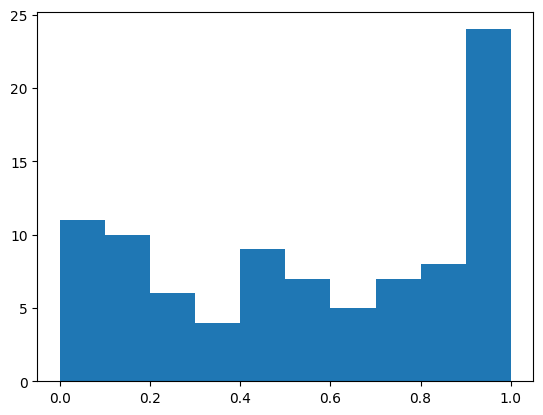

In [45]:
pv_df_test = create_pval_df(pval)
#plt.hist(pval_df['p-valeur'])
plt.hist(pv_df_test['p-valeur'])

In [46]:
# la p-valeur est égale à 1 quand on passe (quasiment) exactement autant de fois par un chemin que par l'autre

for i in range(len(pval)):
    if pval[i][0] == 1:
        print(table_contingence(pval[i][1]))

           g0  g1
19>21>22   30  31
>19>20>22  30  29
           g0  g1
25>27>28   35  35
>25>26>28  25  25
           g0  g1
31>32>34   31  32
>31>33>34  29  28
           g0  g1
43>44>46   21  21
>43>45>46  39  39
                 g0  g1
84>89            51  51
>84>85>86>88>89   3   3
>84>85>87>88>89   6   6
              g0  g1
116>118>119   30  30
>116>117>119  30  30
              g0  g1
176>178       11  11
>176>177>178  49  49
              g0  g1
181>182>184   52  51
>181>183>184   8   9
              g0  g1
184>185>187   45  46
>184>186>187  15  14
              g0  g1
195>197>198   45  46
>195>196>198  15  14
              g0  g1
198>199>201   46  47
>198>200>201  14  13
              g0  g1
239>240>242   46  46
>239>241>242  14  14
              g0  g1
263>265>266   26  27
>263>264>266  34  33
              g0  g1
269>270>272   53  52
>269>271>272   7   8
                                     g0  g1
275>276>277>279>280>282>284>285>286   1   1
>275>286                         

In [ ]:
''' print(table_contingence(i))
print(table_contingence(i).sum(axis = 0))
print(contingence_pb[i])''' 

    
'''print(len(snarl_index_somme_pas_ok))
print(snarl_index_somme_pas_ok)
for i in snarl_index_somme_pas_ok:
    if i in zero_dans_contingence_snarl:
        print(i)'''

'''    print('--------------------')
    print(contingence_pb[i])
    print('####################')''';

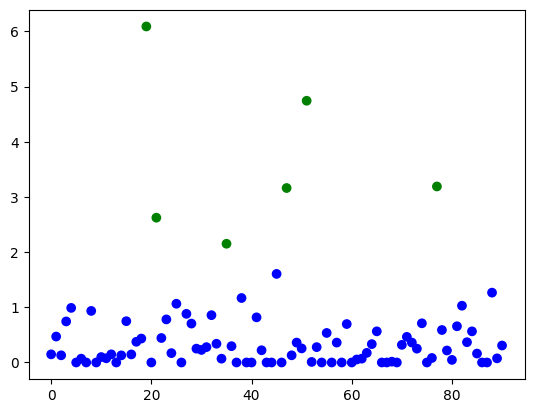

In [13]:
# manhattan plot

#fig = plt.figure(figsize=(14, 8)) 
#ax = fig.add_subplot(111)
plt.scatter(range(len(pv_df_test)), pv_df_test['moinslog10pvaleur'], c=pv_df_test['color'])
#ax.set_xlabel('snarl index')
#ax.set_ylabel('moins log10 pvalue')


In [14]:
# find the smallest pvalues and the associated snarls   

for i in range(len(pv_df_test)):
    if pv_df_test['moinslog10pvaleur'].iloc[i] > 2:
    # if pval_df.index[i] == '446>449':
        # print(pval_df['moinslog10pvaleur'].iloc[i])
        print('##########', pv_df_test['moinslog10pvaleur'].iloc[i])
        print(table_contingence(pv_df_test.index[i]))

########## 6.089961181235811
                g0  g1
79>80>81>83>84  15  43
>79>84          45  17
########## 2.624205309601664
           g0  g1
89>91>92   35  51
>89>90>92  25   9
########## 2.15176597063122
              g0  g1
170>171>173   56  44
>170>172>173   4  16
########## 3.1620872897202483
              g0  g1
242>243>245   47  28
>242>244>245  13  32
########## 4.743716244978902
             g0  g1
254>255>256  52  29
>254>256      8  31
########## 3.1902936329226557
              g0  g1
446>448>449   54  37
>446>447>449   6  23


In [15]:
# snarl untrue ? donne des meilleurs noms à tes variables 

snarl_untrue = ['198>201', '201>204', '427>438', '497>502']
for i in range(len(pv_df_test.index)):
    if pv_df_test.index[i] in snarl_untrue:
        print('##############', pv_df_test.index[i], ';',  pv_df_test['moinslog10pvaleur'].iloc[i])  
        print(table_contingence(pv_df_test.index[i]))


############## 198>201 ; -0.0
              g0  g1
198>199>201   46  47
>198>200>201  14  13
############## 201>204 ; 1.605206062014734
              g0  g1
201>203>204   30  43
>201>202>204  30  17
############## 427>438 ; 0.25056113047429746
                                      g0  g1
427>428>429>431>433>434>436>437>438   16   7
>427>428>429>431>432>434>435>437>438  18  13
############## 497>502 ; 1.2658205505845004
                      g0  g1
497>498>500>501>502    2   2
>497>502              22  35
>497>498>499>501>502  36  23


In [41]:
# trafiquer les tables de contingences 
## on ne veut plus de 0 dans les tables
## on veut pas changer les effectifs par colonnes 

contingence_pb = [table_contingence(i) for i in zero_dans_contingence_snarl]
snarl_index_somme_pas_ok = []

'''for i in snarl_df.index.unique():
    if table_contingence(i).sum(axis = 0).iloc[0] != 60 or table_contingence(i).sum(axis = 0).iloc[1] != 60:
        snarl_index_somme_pas_ok.append(i)'''
for i in range(len(contingence_pb)):
    contingence_pb[i] = contingence_pb[i].where(contingence_pb[i] != 0, contingence_pb[i]+1)
    contingence_pb[i] = contingence_pb[i].where(contingence_pb[i] != contingence_pb[i].max().max(), contingence_pb[i]-1)
''' print(table_contingence(i))
print(table_contingence(i).sum(axis = 0))
print(contingence_pb[i])''' 

    
'''print(len(snarl_index_somme_pas_ok))
print(snarl_index_somme_pas_ok)
for i in snarl_index_somme_pas_ok:
    if i in zero_dans_contingence_snarl:
        print(i)'''

'''    print('--------------------')
    print(contingence_pb[i])
    print('####################')''';

In [35]:
contingence_pb[-5]

,g0,g1
204>205>206>208>210>211>213>214>215>217>219>220>221>223>224>226>228>229>230>232>234>235>236>238>239,6,6
>204>205>206>208>209>211>213>214>215>217>219>220>221>223>224>226>228>229>230>232>234>235>236>238>239,2,1


In [ ]:
print(table_contingence('79>84'))
print(table_contingence('60>71'))
print(table_contingence('4>9'))
vcf1_df

Text(0.5, 1.0, 'all moins log10 pvalues')

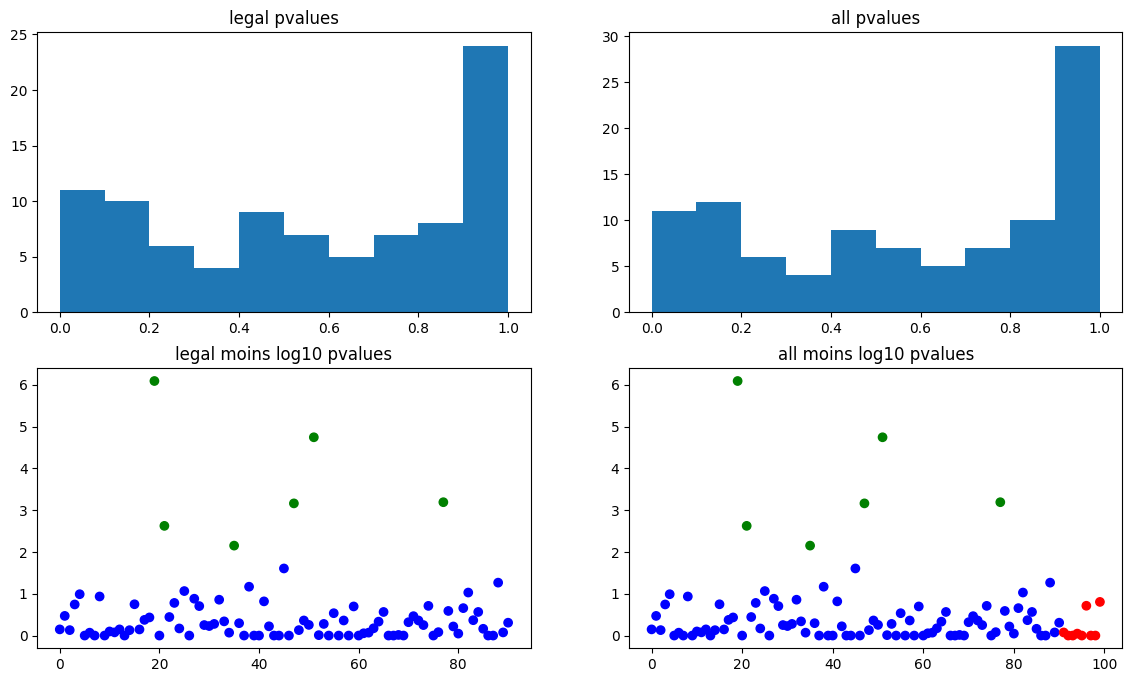

In [36]:
# pval_pb = [(chi2(table_contingence(i)), i) for i in zero_dans_contingence_snarl]
pval_pb = [[chi2(i), 0] for i in contingence_pb]
for i in range(len(pval_pb)):
    pval_pb[i][1] = zero_dans_contingence_snarl[i]
pval_all = pval + pval_pb

pval_all_df = create_pval_df(pval_all)
for i in pval_all_df.index:
    if i not in pv_df_test.index:
        pval_all_df.loc[i, 'color'] = "red"
 
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
ax[0][0].hist(pv_df_test['p-valeur'])
ax[0][0].set_title('legal pvalues')
ax[0][1].hist(pval_all_df['p-valeur'])
ax[0][1].set_title('all pvalues')

ax[1][0].scatter(range(len(pv_df_test)), pv_df_test['moinslog10pvaleur'], c=pv_df_test['color'])
ax[1][0].set_title('legal moins log10 pvalues')
ax[1][1].scatter(range(len(pval_all_df)), pval_all_df['moinslog10pvaleur'], c=pval_all_df['color'])
ax[1][1].set_title('all moins log10 pvalues')
#plt.hist(pval_all)

In [37]:
# proof (pour moi même) that the two df are not identical 
# par contre trafiquer les tables de contingences n'a pas permis d'avoir de petites pvaleurs 
print(len(pv_df_test), len(pval_all_df))

91 100


## la suite

In [ ]:
 # cb de snarls avec n chemins possibles ?
from itertools import groupby

length_of_paths = []
for i in list(snarl_df.index):
    length_of_paths.append(list(snarl_df.index).count(i))
    
# occ = [[x,ind.count(x)] for x in set(ind)]

taille_chem = list(set(length_of_paths))
freq_taille = [len(list(group)) for key, group in groupby(sorted(length_of_paths))]

print(taille_chem, freq_taille)

 # 'Play' with bdsg
##### am i playing with bdsg or is bdsg playing with me

In [ ]:
from bdsg.bdsg import HashGraph

gr = HashGraph()
seq = ["CGA", "TTGG", "CCGT", "C", "GT", "GATAA", "CGG", "ACA", "GCCG", "ATATAAC"]
n = []
for s in seq:
    n.append(gr.create_handle(s))

gr.create_edge(n[0], n[1])
gr.create_edge(n[1], n[2])
gr.create_edge(n[2], n[3])
gr.create_edge(n[2], n[4])
gr.create_edge(n[3], n[5])
gr.create_edge(n[5], n[6])
# Connect the end of n5 to the start of n8
gr.create_edge(n[5], n[8])
gr.create_edge(n[6], n[7])
gr.create_edge(n[6], n[8])
gr.create_edge(n[7], n[9])
gr.create_edge(n[8], n[9])
# Connect the end of n8 back around to the start of n5
gr.create_edge(n[8], n[5])

def next_node_list(handle):
    lis = []
    gr.follow_edges(handle, False, lambda y: lis.append(y))
    return lis

print(n)

print(f'n0: {gr.get_sequence(n[0])}')
next_node = next_node_list(n[0])[0]
print(f'n1: {gr.get_sequence(next_node)}')
next_node = next_node_list(next_node)[0]
print(f'n2: {gr.get_sequence(next_node)}')

path = gr.create_path_handle("path")
gr.append_step(path, n[0])
gr.append_step(path, n[1])
gr.append_step(path, n[2])
gr.append_step(path, n[4])
gr.append_step(path, n[5])
gr.append_step(path, n[6])
gr.append_step(path, n[7])
gr.append_step(path, n[9])

In [ ]:
from bdsg.bdsg import PackedGraph
brca2 = PackedGraph()
brca2.deserialize("/home/yboulkaid/Documents/sample_data/pgtest.data/pg.pg")
#brca2.deserialize("/home/yboulkaid/Téléchargements/cactus-brca2.pg")

path_handle = []
handles = []
brca2.for_each_path_handle(lambda y: path_handle.append(y) or True)
brca2.for_each_step_in_path(path_handle[0],
    lambda y: handles.append(brca2.get_handle_of_step(y)) or True)
sequence = ""
for handle in handles:
    sequence += brca2.get_sequence(handle)
print(sequence[0:10])
print(len(sequence))


In [ ]:
type(gr)

# CACGTCCGAGAATCGG
# CACGTCCGAG

In [ ]:
from bdsg.handlegraph import  HandleGraph
###########################################
### HOW TO ACCESS THE SNARL TREE (XIAN) ###
###########################################

# load the snarl tree
stree = bdsg.bdsg.SnarlDistanceIndex()
stree.deserialize("pg.dist")
# Note: make the pg.dist from the pg.pg using: vg index -j pg.dist pg.pg

# load the graph
pg = bdsg.bdsg.PackedGraph()
pg.deserialize("pg.pg")

## To practice let's save all the nodes in the snarl tree in a list
stnodes = []
# find the object pointing to the root of the snarl tree
root = distance_index.get_root()
# the function we want to run on each child of a snarl tree node
def save_snarl_tree_node(stnode):
    # FILL
    #   here for example, save the input in the list and iterate on its potential children
    # if the function returns True, the iteration will continue (which is what we want in this case)
    return(True)
# run that function, starting from the rood node of the tree
stree.for_each_child(root, save_snarl_tree_node)
# note: for_each_child can only be run on elements that have children (i.e. chains and snarls), not nodes or sentinels.

## Understanding elements of the snarl tree
# get one of the snarl tree nodes saved earlier
stn = stnodes[3]
# print it's "string" summary
stree.net_handle_as_string(stn)
# check which type it is
stree.is_chain(stn)
stree.is_snarl(stn)
stree.is_sentinel(stn)
stree.is_node(stn)

## Manipulating a snarl
# assuming we have a snarl, get the boundary nodes
stn_start = stree.get_bound(stn, False, True)
stn_end = stree.get_bound(stn, True, True)
# get the actual node, not the sentinel (~fake boundary nodes?)
stn_start = stree.get_node_from_sentinel(stn_start)
stn_end = stree.get_node_from_sentinel(stn_end)
stn_end = stree.flip(stn_end) # flip the end handle (I think, to be confirmed)
# get a node id
stree.node_id(stn_start)
# get a handle/object of that node in the graph
stn_start_pg = stree.get_handle(stn_start, pg)
stn_end_pg = stree.get_handle(stn_end, pg)
# get the ID of an element in the graph, here a node
pg.get_id(stn_start_pg)
# test if there is an edge between two nodes in the graph
pg.has_edge(stn_start_pg, stn_end_pg)


In [ ]:
print(ngraph)
print(distance_index.net_handle_as_string(ngraph['n'][0]))

In [ ]:
ngraph['n']

In [ ]:
distance_index.deserialize("/home/yboulkaid/Documents/sample_data/pgtest.data/pg.dist")

In [ ]:
'''get parent 
get child 
get bound 
get root'''